Downloaded from ...

https://www.tensorflow.org/text/tutorials/text_classification_rnn

on ...

Thursday, January 12, 2023

KAUWITB

conda activate tf211

In [1]:
# docker run --gpus all -it -v $(realpath ~/):/tf/All -v /home/rob/Data2:/home/rob/Data2 --env HF_DATASETS_CACHE=/home/rob/Data2/huggingface/datasets --env TRANSFORMERS_CACHE=/home/rob/Data2/huggingface/transformers -p 8888:8888 -p 6006:6006 tf211:20221217

# This all runs. Nice!
# Run Date: Friday, January 13, 2023
# Run Time: 00:10:06

import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

##### Copyright 2018 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [3]:
!pip install ipywidgets

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf


# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     # Restrict TensorFlow to only use the first GPU
#     try:
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#         logical_gpus = tf.config.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#     except RuntimeError as e:
#         # Visible devices must be set before GPUs have been initialized
#         print(e)

tfds.disable_progress_bar()

2023-01-13 13:08:14.702665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Import `matplotlib` and create a helper function to plot graphs:

In [5]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [6]:
# dataDirectory. Notice it is outside this repo.
dataDir = '/home/rob/Data/Documents/Github/rkaunismaa/data/'

In [7]:
# dataset, info = tfds.load('imdb_reviews', with_info=True,
#                           as_supervised=True)

dataset, info = tfds.load('imdb_reviews', data_dir=dataDir,  with_info=True,
                          as_supervised=True)

# train_dataset, test_dataset = dataset['train'], dataset['test']

# train_dataset.element_spec

2023-01-13 13:08:16.344696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 13:08:16.344864: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 13:08:16.347005: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 13:08:16.347176: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-13 13:08:16.347304: I tensorflow/compiler/xla/stream_executo

In [8]:
train_dataset, test_dataset = dataset['train'], dataset['test']

In [9]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [10]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2023-01-13 13:08:16.981173: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'The documentary revolves around Eva Mozes Kor, a holocaust survivor, part of Mengele\'s experiments on twins, consisting primarily her version of what happened at Auschwitz, and a comparison of the emotions of the other survivors of the twin experiments. The movie obviously had great reviews. It\'s one of those topics that no one dares to voice a contrary opinion about.<br /><br />I too, for a large part of the movie, got sucked into the emotion that the movie-maker so obviously wanted the viewer to concentrate on. One of the user reviews on IMDb by Eric Monder (obviously having nothing critical to say about the issue on a public forum) could only find the sweetest nectar. "In one of the many dramatic sequences, as a group of Jews argue with Kor at a Jewish center, the meaning of the word "forgive" is even debated, but the isolated and outnumbered Kor holds her own" But by this time, the sappy hold that the movie had on my dormant emotional repertoire had let loose enough th

2023-01-13 13:08:17.146619: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [14]:
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

encoder.adapt(train_dataset.map(lambda text, label: text))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [15]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [16]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 671,   1, ...,   0,   0,   0],
       [134, 136,   4, ...,   0,   0,   0],
       [414,  83,  24, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [17]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'The documentary revolves around Eva Mozes Kor, a holocaust survivor, part of Mengele\'s experiments on twins, consisting primarily her version of what happened at Auschwitz, and a comparison of the emotions of the other survivors of the twin experiments. The movie obviously had great reviews. It\'s one of those topics that no one dares to voice a contrary opinion about.<br /><br />I too, for a large part of the movie, got sucked into the emotion that the movie-maker so obviously wanted the viewer to concentrate on. One of the user reviews on IMDb by Eric Monder (obviously having nothing critical to say about the issue on a public forum) could only find the sweetest nectar. "In one of the many dramatic sequences, as a group of Jews argue with Kor at a Jewish center, the meaning of the word "forgive" is even debated, but the isolated and outnumbered Kor holds her own" But by this time, the sappy hold that the movie had on my dormant emotional repertoire had let loose enough 

## Create the model

![A drawing of the information flow in the model](images/bidirectional.png)

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [18]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [19]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [20]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))

print(predictions[0])

2023-01-13 13:08:21.709753: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step
[0.00074029]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [21]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 78ms/step
[0.00074029]


Compile the Keras model to configure the training process:

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [23]:
%%time
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


2023-01-13 13:08:26.424963: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	while inferring type of node 'cond_40/output/_23'
2023-01-13 13:08:26.757950: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f103ca9d280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-13 13:08:26.757977: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-01

391/391 [==============================] - 34s 73ms/step - loss: 0.6496 - accuracy: 0.5637 - val_loss: 0.5195 - val_accuracy: 0.7797
Epoch 2/10
  3/391 [..............................] - ETA: 16s - loss: 0.5257 - accuracy: 0.7552

2023-01-13 13:08:56.057270: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 21s 53ms/step - loss: 0.4222 - accuracy: 0.8117 - val_loss: 0.3783 - val_accuracy: 0.8427
Epoch 3/10
  3/391 [..............................] - ETA: 14s - loss: 0.3356 - accuracy: 0.8750

2023-01-13 13:09:16.986107: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 52ms/step - loss: 0.3496 - accuracy: 0.8490 - val_loss: 0.3445 - val_accuracy: 0.8448
Epoch 4/10
  3/391 [..............................] - ETA: 20s - loss: 0.3236 - accuracy: 0.8750

2023-01-13 13:09:37.247241: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 51ms/step - loss: 0.3245 - accuracy: 0.8594 - val_loss: 0.3288 - val_accuracy: 0.8583
Epoch 5/10
  3/391 [..............................] - ETA: 18s - loss: 0.3853 - accuracy: 0.8125

2023-01-13 13:09:57.053335: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 51ms/step - loss: 0.3115 - accuracy: 0.8672 - val_loss: 0.3312 - val_accuracy: 0.8500
Epoch 6/10
  3/391 [..............................] - ETA: 18s - loss: 0.3340 - accuracy: 0.8594

2023-01-13 13:10:17.096972: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 51ms/step - loss: 0.3067 - accuracy: 0.8680 - val_loss: 0.3272 - val_accuracy: 0.8630
Epoch 7/10
  1/391 [..............................] - ETA: 36s - loss: 0.2427 - accuracy: 0.9219

2023-01-13 13:10:37.001833: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 50ms/step - loss: 0.3030 - accuracy: 0.8712 - val_loss: 0.3208 - val_accuracy: 0.8594
Epoch 8/10
  3/391 [..............................] - ETA: 15s - loss: 0.3141 - accuracy: 0.8646

2023-01-13 13:10:56.699077: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 51ms/step - loss: 0.2985 - accuracy: 0.8734 - val_loss: 0.3195 - val_accuracy: 0.8615
Epoch 9/10
  3/391 [..............................] - ETA: 19s - loss: 0.3350 - accuracy: 0.8698

2023-01-13 13:11:16.573362: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 51ms/step - loss: 0.2974 - accuracy: 0.8743 - val_loss: 0.3312 - val_accuracy: 0.8615
Epoch 10/10
  3/391 [..............................] - ETA: 19s - loss: 0.3357 - accuracy: 0.8594

2023-01-13 13:11:36.514912: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 20s 51ms/step - loss: 0.2958 - accuracy: 0.8769 - val_loss: 0.3223 - val_accuracy: 0.8583
CPU times: user 3min 42s, sys: 9.16 s, total: 3min 51s
Wall time: 3min 34s


2023-01-13 13:11:56.412807: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 11s 27ms/step - loss: 0.3176 - accuracy: 0.8546
Test Loss: 0.31755128502845764
Test Accuracy: 0.854640007019043


(0.0, 0.6673210769891739)

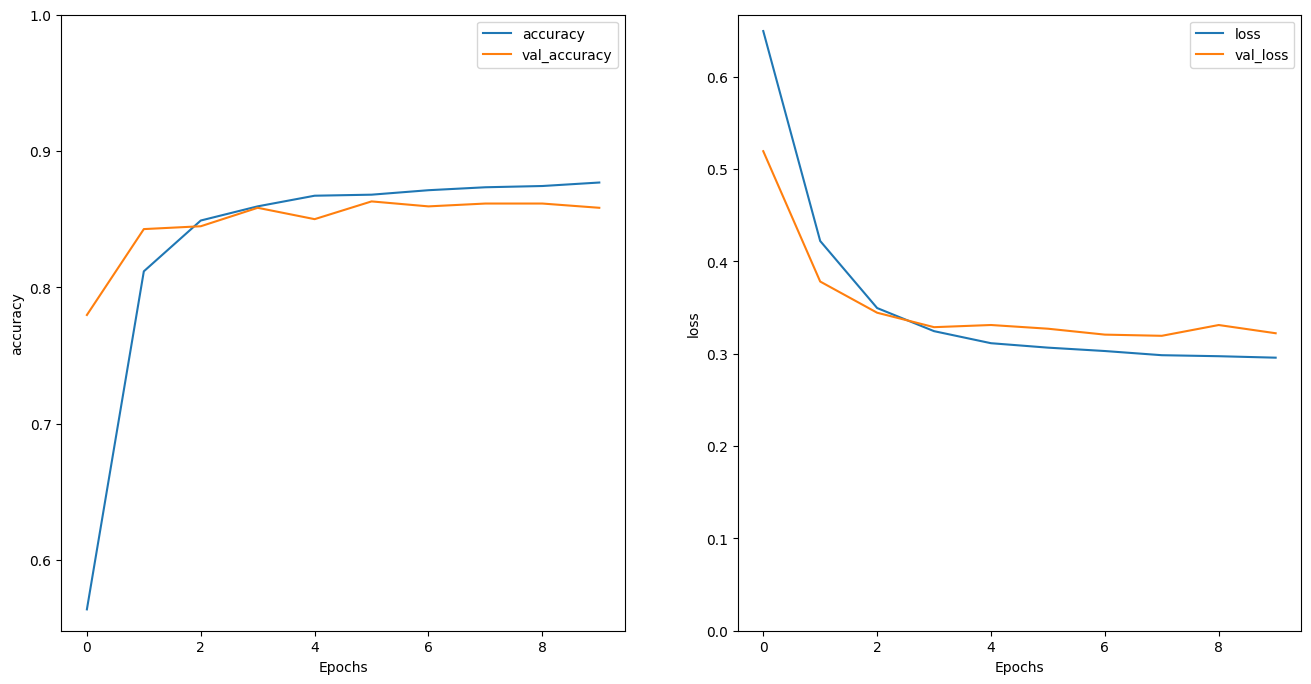

In [25]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [26]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [27]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [29]:
%%time
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 50s 104ms/step - loss: 0.6730 - accuracy: 0.5248 - val_loss: 0.6359 - val_accuracy: 0.6474
Epoch 2/10
391/391 [==============================] - 36s 93ms/step - loss: 0.5133 - accuracy: 0.7472 - val_loss: 0.4284 - val_accuracy: 0.7964
Epoch 3/10
391/391 [==============================] - 35s 89ms/step - loss: 0.3945 - accuracy: 0.8274 - val_loss: 0.3732 - val_accuracy: 0.8219
Epoch 4/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3565 - accuracy: 0.8452 - val_loss: 0.3495 - val_accuracy: 0.8469
Epoch 5/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3391 - accuracy: 0.8537 - val_loss: 0.3353 - val_accuracy: 0.8516
Epoch 6/10
391/391 [==============================] - 32s 81ms/step - loss: 0.3265 - accuracy: 0.8610 - val_loss: 0.3272 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 33s 84ms/step - loss: 0.3209 - accuracy: 0.8636 - val_loss: 0.3407 - val_accuracy

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 16s 40ms/step - loss: 0.3259 - accuracy: 0.8603
Test Loss: 0.32594624161720276
Test Accuracy: 0.860319972038269


In [31]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 3s 3s/step
[[-2.0123518]]


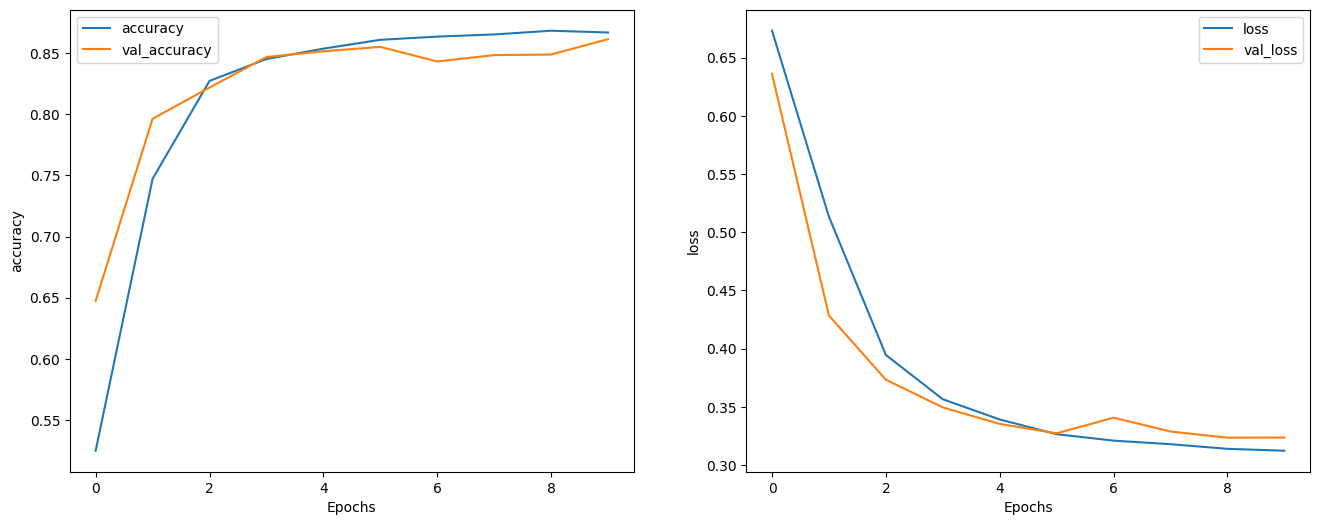

In [32]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).


In [33]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Friday, January 13, 2023
# Run Time: 00:10:06
